## Center of Mass trajectory and analysis

The module MemSys.py defines classes used to build a Center of Mass (COM) trajectory out of the original trajectory. There are various analyses that can be performed using this type of representation. Some examples that are built in to the module will be demonstrated later in this document. 

### The MemSys object

In the MemSys module their is a class (perhaps poorly) named MemSys, which is the primary object that will be used for the COM trajectory. We will first demonstrate construction of this object and discuss some of its structure and function. 

To begin we will import the modules we'll use.

In [2]:
#MDAnalysis
import MDAnalysis as mda
#The MemSys module
import MemSys as com_traj
#Plotting Functions 
%matplotlib inline
import plot_generation_functions as pgf

Now we can construct the MDAnalysis universe object (we'll use a provided test bilayer system).

In [3]:
u = mda.Universe('test_system/mem2.psf','test_system/mem2_1_fr10.dcd')

Now we need to select the bilayer atoms.


In [4]:
bilayer = u.select_atoms("not resname CLA and not resname TIP3 and not resname POT")

And now we can build the MemSys (or COM trajectory) object.

In [22]:
mem_sys = com_traj.MemSys(u.trajectory, bilayer, frame_path='./test_system/test_output/')

doing frame  0
time  0.0
doing frame  1
time  0.04888821
doing frame  2
time  0.09777642
doing frame  3
time  0.14666463
doing frame  4
time  0.19555284
doing frame  5
time  0.24444105
doing frame  6
time  0.29332926
doing frame  7
time  0.34221747
doing frame  8
time  0.39110568
doing frame  9
time  0.43999389


In [15]:
print mem_sys

Membrane System with 10 frames and 600 lipids/components


The MemSys initializer reqiures the MDAnalysis trajectory object and an atom selection object. We suggest also setting the optional frame_path variable, which is where the COM trajectory data will be stored on disk. The com trajectory can be left saved on disk after the session by also setting the 'frame_save' flag to True.

By default the the xy plane is assumed to be the lateral dimension of the bilayer, and the z direction is assumed to be along the bilayer normal. However, these can be specified at initialization via the 'plane' input variable string if your bilayer has a different orientation. 

In [31]:
# Re-initialize, but specify the later plane
mem_sys_b = com_traj.MemSys(u.trajectory, bilayer, plane='xy', frame_path='./test_system/test_output/')

doing frame  0
time  0.0
doing frame  1
time  0.04888821
doing frame  2
time  0.09777642
doing frame  3
time  0.14666463
doing frame  4
time  0.19555284
doing frame  5
time  0.24444105
doing frame  6
time  0.29332926
doing frame  7
time  0.34221747
doing frame  8
time  0.39110568
doing frame  9
time  0.43999389


The options for specifying the lateral plane are 'xy' (the default), 'yz', and 'xz', or their equivalents 'yx', 'zy', and 'zx'. 

#### Frames
The first major part of the MemSys object is the 'frame' member variable.

In [18]:
print mem_sys.frame

<MemSys.frames instance at 0x7f043d001290>


We can see that it is an instance of the MemSys.frames class, which is a container that stores the COM trajectory frames on disc using the Shelve module (https://docs.python.org/2/library/shelve.html). We can check the number of frames stored in the object either by accessing the 'nframes' member variable of the mem_sys instance or by using len on the 'frame' variable.

In [20]:
print mem_sys.nframes
print len(mem_sys.frame)

10
10


Individual frames can accessed by indexing the 'mem_sys.frame' variable.

In [24]:
print mem_sys.frame[0]

<MemSys.Frame instance at 0x7f043ce69ea8>


In [25]:
#len returns the number COMs (or lipids) in the Frame instance.
print len(mem_sys.frame[0])

600


Although the frames can be indexed individully, there are some built in analyses that automatically handle looping over frames and doing their specific computations. However, there are times when indexing the frames is necessary. These include custom anlaysis or when working with the memsys_leaflet_gridding module. 

#### Leaflets
The next major component of the MemSys class instance is the 'leaflets' member variable. This is a dictionary with two keys: 'upper' and 'lower'. 

In [27]:
print mem_sys.leaflets

{'upper': upper leaflet of a Membrane System with 300 members and 3 lipid groups, 'lower': lower leaflet of a Membrane System with 300 members and 3 lipid groups}


When the MemSys class instance is initialized it automatically uses the first frame to sort the lipids into an 'upper' and 'lower' leaflet. 

###### Note:
The average position along the bilayer normal is currently used to divide the leaflets, so if you are working with highly curved bilayers this process will likely be inaccurate (functionality to handle this problem is the topic of future development). 

The indivdiual leafleat objects stored in the dictionary contain information about the number of lipids in that leaflet, as well as the types of lipids (assigned by their MDAnalysis resname). 

In [28]:
#Access the 'upper' leaflet
print mem_sys.leaflets['upper']

upper leaflet of a Membrane System with 300 members and 3 lipid groups


In [29]:
# Check the types of lipids in that leaflet
print mem_sys.leaflets['upper'].GetGroupNames()

['POPC', 'TLCL2', 'DOPE']


The leaflets construct allows many analyses, such as Mean Squared Displacement (MSD), to be performed on a per leaflet level. The grouping construct stored in the leaflet then allows for per lipid type analysis. 

#### Example anlysis- Mean Squared Displacement (MSD)
As an example let's go ahead and look at computing some MSDs. 

In [34]:
# compute the global MSD (in the lateral dimensions of the bilayer)
msd_global = mem_sys.CalcMSD()
print msd_global

[[ 0.          0.        ]
 [ 0.04888821  0.57014543]
 [ 0.09777642  0.83566515]
 [ 0.14666463  0.9216467 ]
 [ 0.19555284  1.11987873]
 [ 0.24444105  1.32089826]
 [ 0.29332926  1.55354826]
 [ 0.34221747  1.91665934]
 [ 0.39110568  2.10194152]
 [ 0.43999389  2.35802145]]


The CalcMSD function returns nframesx2 numpy array of the time series MSD values. The left column is the simulation time and the right is the MSD value (averaged over all the lipids).
Now we can take advantage of the leaflet and grouping structure to compute the MSD of specific groupings of the lipids.

In [35]:
#MSD for the upper leaflet
msd_upper = mem_sys.CalcMSD(leaflet='upper')
#MSD for the lower leaflet
msd_lower = mem_sys.CalcMSD(leaflet='lower')
#MSD for POPC (in both leaflets)
msd_popc = mem_sys.CalcMSD(group='POPC')
#MSD for DOPE in the upper leaflet
msd_dope_upper = mem_sys.CalcMSD(leaflet='upper', group='DOPE')

Now let's plot these data. We'll use the template plotting function 'plot_msd' in the plot_generation_function module.

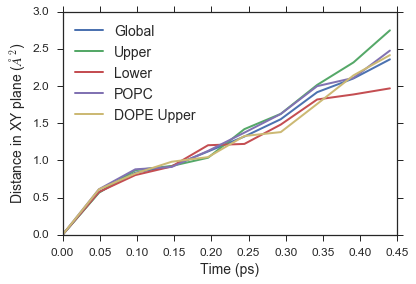

In [37]:
#plot the MSD data
pgf.plot_msd([msd_global, msd_upper, msd_lower, msd_popc, msd_dope_upper], name_list=['Global','Upper','Lower','POPC','DOPE Upper'], filename='./test_system/test_output/msd.eps', show=True, time_out='ps')

There is also a multithreaded version of the MSD computation that is provided. This version parallelizes the loop over the frames, so is very helpful when the trajectory is large and their are a lot frames.

In [39]:
#compute MSD for POPC using multithreaded version
msd_popc_mt = mem_sys.CalcMSD_parallel(group='POPC', nprocs=2)

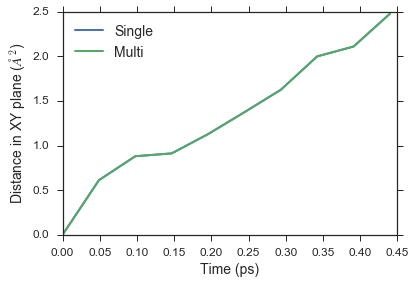

In [40]:
#Now plot
pgf.plot_msd([msd_popc, msd_popc_mt], name_list=['Single','Multi'], time_out='ps', filename='./test_system/test_output/msd_mt.eps', show=True)

#### Examples of some other included anlayses

##### Area Per Lipid
The MemSys class object has two built-in estimators of the area per lipid. One simply using the box size data from the trajectory and the number of lipids to estimate the area per lipid, which is accurate for homogenous bilayers. 

In [41]:
#Area per lipid using box size
apl_box = mem_sys.CalcAreaPerLipid_Box(leaflet="both")

In [46]:
print apl_box

[[  0.00000000e+00   7.42801931e+01   7.42801931e+01   0.00000000e+00]
 [  4.88882100e-02   7.44916480e+01   7.43859205e+01   1.49521247e-01]
 [  9.77764200e-02   7.41724311e+01   7.43147574e+01   1.62391147e-01]
 [  1.46664630e-01   7.41914761e+01   7.42839371e+01   1.46219549e-01]
 [  1.95552840e-01   7.43717284e+01   7.43014953e+01   1.32576697e-01]
 [  2.44441050e-01   7.45077683e+01   7.43358742e+01   1.45439635e-01]
 [  2.93329260e-01   7.42973232e+01   7.43303669e+01   1.33564782e-01]
 [  3.42217470e-01   7.43610013e+01   7.43341962e+01   1.24130383e-01]
 [  3.91105680e-01   7.43570966e+01   7.43367407e+01   1.16363989e-01]
 [  4.39993890e-01   7.45120268e+01   7.43542693e+01   1.22917010e-01]]


However, for heterogeneous bilayers it is effectively the composite average over all lipid types, and doesn't give us any information about the area occuppied by a specific lipid type.

Therefore a another estimator is provided that allows us to do the calculation by lipid type, and although this function is a more expensive computation, it allows for a rough estimation of per lipid type values.  

In [42]:
#Area per lipid using nearest neighbor distances
apl_nnd = mem_sys.CalcAreaPerLipid_ClosestNeighborCircle(leaflet="both", group="all")

In [43]:
#Area per lipid for POPC
apl_nnd_popc = mem_sys.CalcAreaPerLipid_ClosestNeighborCircle(leaflet="both", group="POPC")
#Area per lipid for DOPE
apl_nnd_dope = mem_sys.CalcAreaPerLipid_ClosestNeighborCircle(leaflet="both", group="DOPE")

Let's plot the values for comparison.

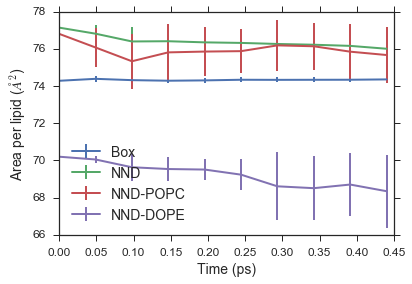

In [49]:
#Plot using template function
pgf.plot_area_per_lipid([apl_box,apl_nnd,apl_nnd_popc, apl_nnd_dope],name_list=['Box','NND','NND-POPC','NND-DOPE'], time_out='ps', filename='./test_system/test_output/apl.eps',show=True)

For more accurate area per lipid estimations we reccommend using the memsys_leaflet_gridding module. 

##### Step/Displacement Vectors and Flow Maps

Another type of analysis/visualization we can do ia create flow maps, which are constructed from displacements of the lipid COMs over intervals of time. This analysis is based on the work of Falck et al. (http://pubs.acs.org/doi/abs/10.1021/ja7103558).

In [52]:
#compute the displacement vectors (in the lateral dimension) of the upper leaflet
disp_vecs = mem_sys.StepVector(leaflet='upper',group='all',fstart=0,fend=-1,fstep=2,wrapped=False)
#get the colors to use for plotting
disp_vec_colors = mem_sys.StepVectorColors(leaflet='upper', group='all')

'disp_vecs' is a list of data needed to produce the flow map. The length of the list is the number intervals computed. 

In [53]:
print len(disp_vecs)

4


In [54]:
print disp_vecs[0]

[[ -0.14125526   4.12947139  -1.19199     -0.64882991]
 [ -4.09419135  10.51957597   0.85952306   0.11020866]
 [  8.07438791  -2.31697149  -0.72596856   1.06088139]
 ..., 
 [-73.91733114  55.07309012  -0.2282957   -0.38001494]
 [ 65.48004155  71.13093549  -0.43539311   0.27611566]
 [-61.20509723 -73.84297307  -0.51082064   0.10892904]]


In [55]:
print disp_vec_colors

(array([[  5.00000000e-01,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00],
       [  5.00000000e-01,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00],
       [  5.00000000e-01,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00],
       ..., 
       [  1.00000000e+00,   1.22464680e-16,   6.12323400e-17,
          1.00000000e+00],
       [  1.00000000e+00,   1.22464680e-16,   6.12323400e-17,
          1.00000000e+00],
       [  1.00000000e+00,   1.22464680e-16,   6.12323400e-17,
          1.00000000e+00]]), {'POPC': array([ 0.5,  0. ,  1. ,  1. ]), 'TLCL2': array([ 0.50392157,  0.99998103,  0.70492555,  1.        ]), 'DOPE': array([  1.00000000e+00,   1.22464680e-16,   6.12323400e-17,
         1.00000000e+00])})


The 'disp_vec_colors' variable is a two element tuple. The first element are the color codes associated with each vector in the flow map we will generate, while the second element is a dictionary of lipid types and the color code associated with that lipid type. 

Now lets make a plot of one of the flows.

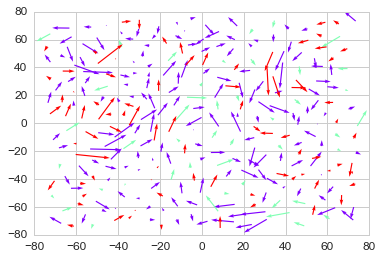

In [56]:
# we need to pass one element of the list, along with the colors.
pgf.plot_step_vectors(disp_vecs[0], colors=disp_vec_colors[0], filename='./test_system/test_output/fmap.eps',show=True)

And now we generate the flow map for the next interval:

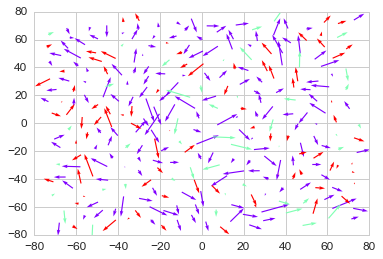

In [57]:
# we need to pass one element of the list, along with the colors.
pgf.plot_step_vectors(disp_vecs[1], colors=disp_vec_colors[0], filename='./test_system/test_output/fmap.eps',show=True)

##### Tesselations

We have also provided some functions that can be used to generate data for Voronoi and Delaunay tesselation maps. These functions use the scipy package to generate the tesselations for each frame using the COM positions. 

In [59]:
#Voronoi tesselations of upper leaflet
vor_tess = mem_sys.VoronoiTesselate(leaflet='upper')


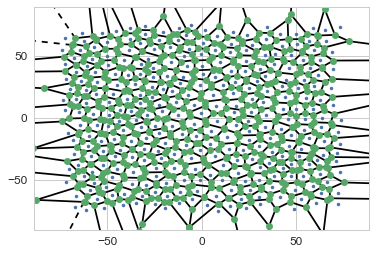

In [60]:
#to plot we need to import from scipy
from scipy.spatial import voronoi_plot_2d
# and let's import pyplot
import matplotlib.pyplot as plt
#generate the plot - pick the first frame
voronoi_plot_2d(vor_tess[0])
plt.show()